# Corona

attacking real Na22 events 

to use:     
1) fetch my (github/abotas) icaro WalkthroughCorona    
2) fetch my IC-1 branch corona.     
3) source manage.sh work_in_blah_blah 3.6   
4) download pmap and dst file for a run    
5) make sure you have IC_DATA and ICARO in your path
6) run

In [2]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.reco.pmaps_functions import load_pmaps, integrate_charge, plot_s2si_map, select_si_slice
from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps
from   invisible_cities.reco.xy_algorithms import barycenter, corona
sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from   icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
from invisible_cities.core.core_functions import in_range

NSIPM = 1792

Load data files

In [3]:
run_number = 3890
sub_run    = '001'
ic_data = os.path.join(os.environ['IC_DATA'])
dst_path  = ic_data + 'LSC/kdst/dst_{}.root.h5'.format(run_number)
pmap_path = ic_data + 'LSC/pmaps/{}/pmaps.gdcsnext.{}_{}.root.h5'.format(run_number, sub_run, run_number)

#### PMAP

In [4]:
S1s, S2s, S2Sis = load_pmaps(pmap_path)

#### DST events in PMAP (Na22 evt candidates) 

In [5]:
full = load_dst(dst_path)
with tb.open_file(pmap_path,'r') as pf:
    sev = pf.root.Run.events[ 0]['evt_number']
    fev = pf.root.Run.events[-1]['evt_number']
Nasr  = full[in_range(full.event, sev, fev+1)]

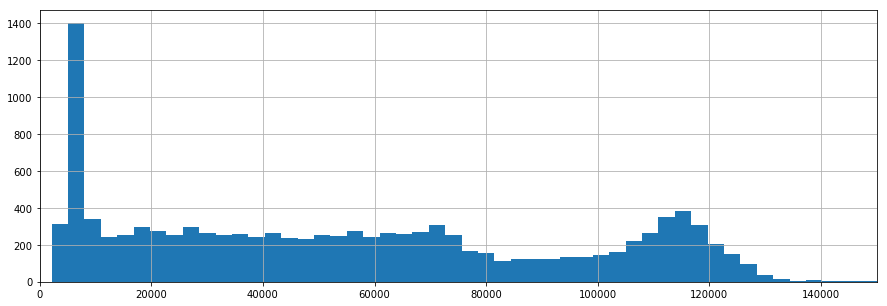

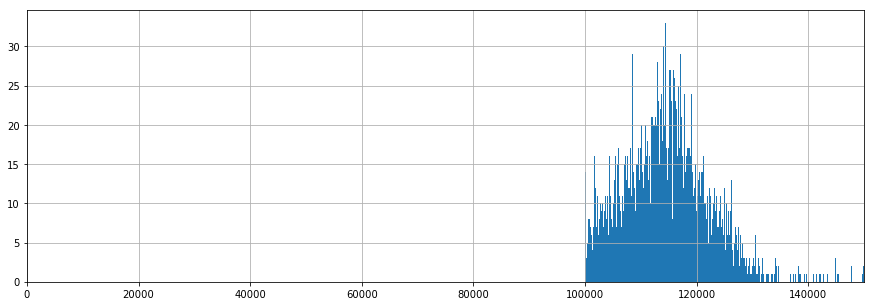

In [17]:
plt.figure(figsize=(15,5))
plt.hist(full.S2e, bins =300)
plt.xlim(0,1.5e5)
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.hist(full[in_range(full.S2e, 1e5, 1.5e5)].S2e, bins =300)
plt.xlim(0,1.5e5)
plt.grid(True)
plt.show()

I am going to further refine my search for events by looking at events with only one S2, just to keep things extra simple.

In [15]:
Nasr    = Nasr[Nasr.nS2 == 1]
#find photopeak
Nasr = Nasr[in_range(Nasr.S2e, 1e5 *units.pes, 1.26e5*units.pes)]
Na_evts = list(set(Nasr.event.values))
peak = 0 # only option after my cut
len(Nasr)

4

In [157]:
# load the SiPM (x,y) values
DataSensor = load_db.DataSiPM()
dxs = DataSensor.X.values
dys = DataSensor.Y.values

In [158]:
# A method in HitCollectionCity
def compute_xy_position(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    
    xs, ys  = dxs[IDs], dys[IDs]
    return corona(xs, ys, Qs, rmax=rmax, T=T, msipm=msipm)

def plot_helper(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    xs, ys  = dxs[IDs], dys[IDs]
    return xs, ys, Qs

# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_slice(l_X,l_Y,l_Q):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,l_Q):
        r = Ellipse(xy=(xx, yy), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(qq);
        ax1.add_artist(r);

    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    return ax1

### Pick an event from the list

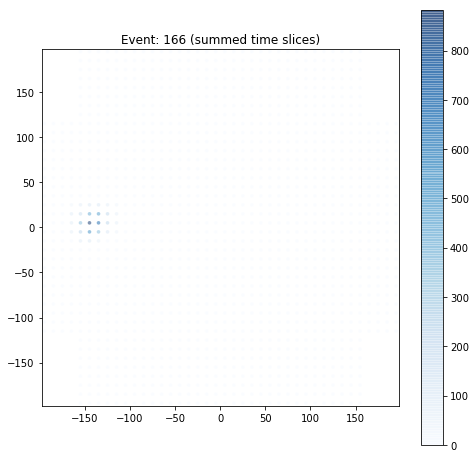

I picked a more interesting looking event


In [173]:
event_numbers, timestamps = get_event_numbers_and_timestamps(pmap_path)
event_number = Na_evts[2]
event_time   = timestamps[np.where(event_numbers==event_number)[0]]
plot_s2si_map(S2Sis[event_number])
plt.title('Event: ' + str(event_number) + ' (summed time slices)')
plt.show()
print('I picked a more interesting looking event')

#### Use corona (via compute_xy_position) to get the clusters for each slice

/Users/alej/miniconda/envs/IC3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


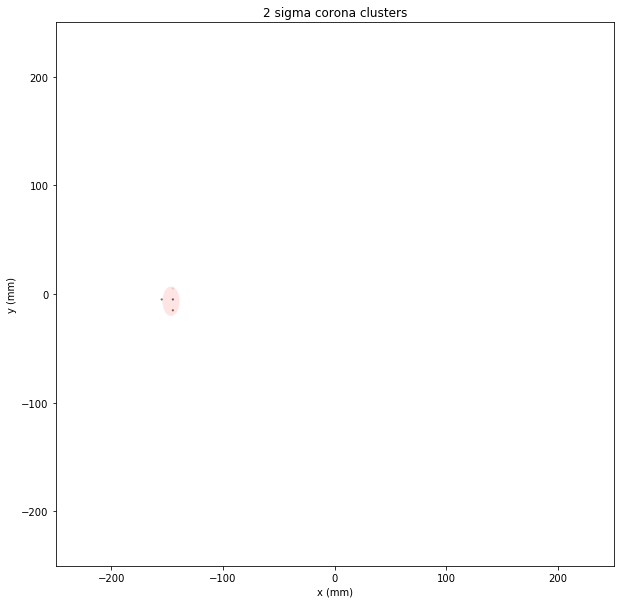

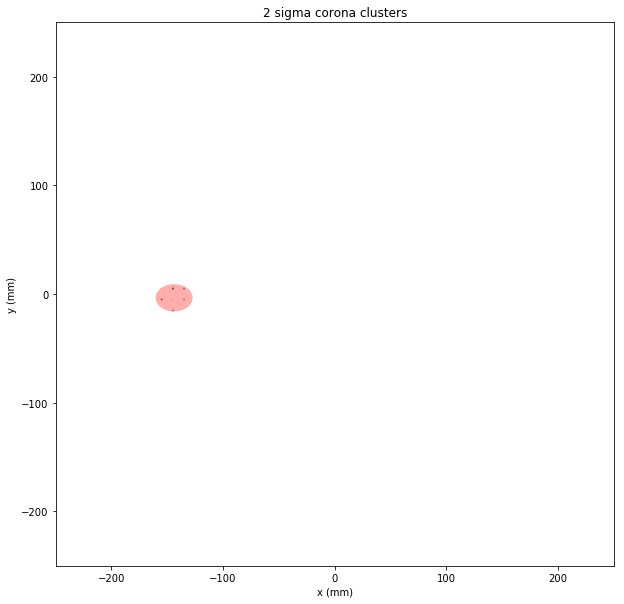

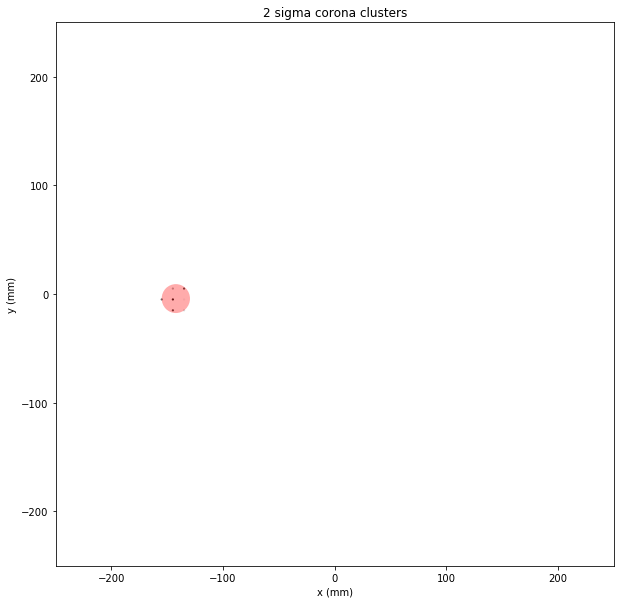

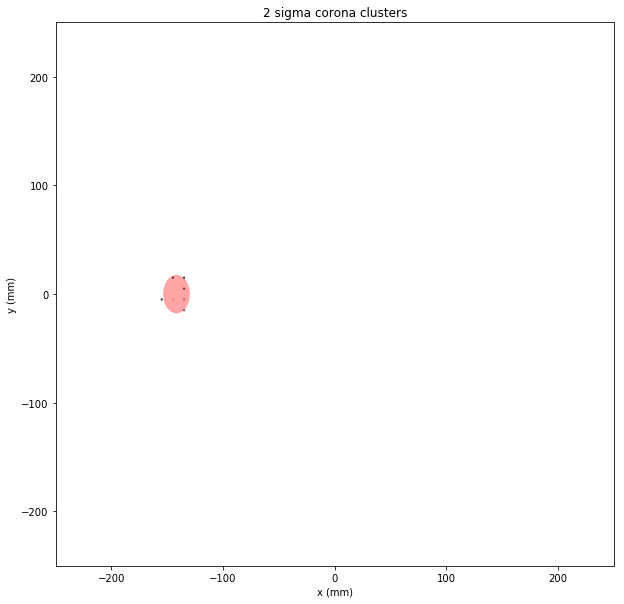

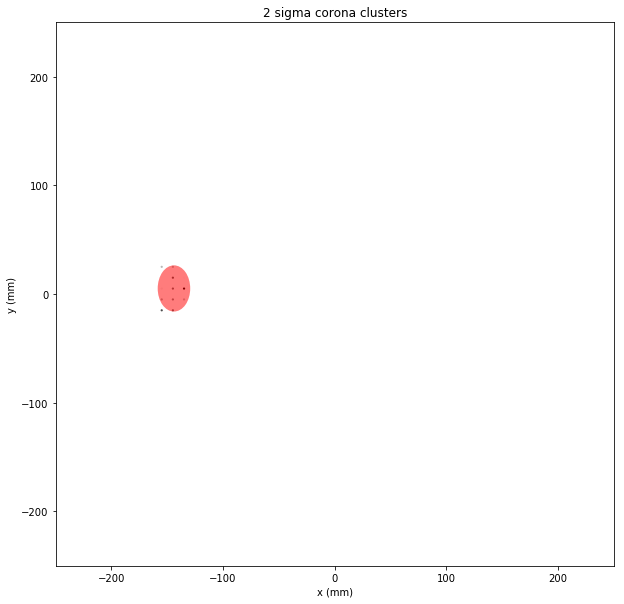

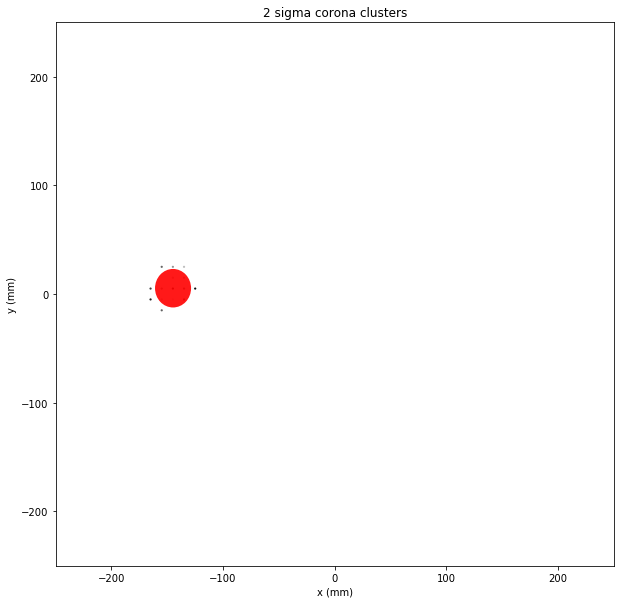

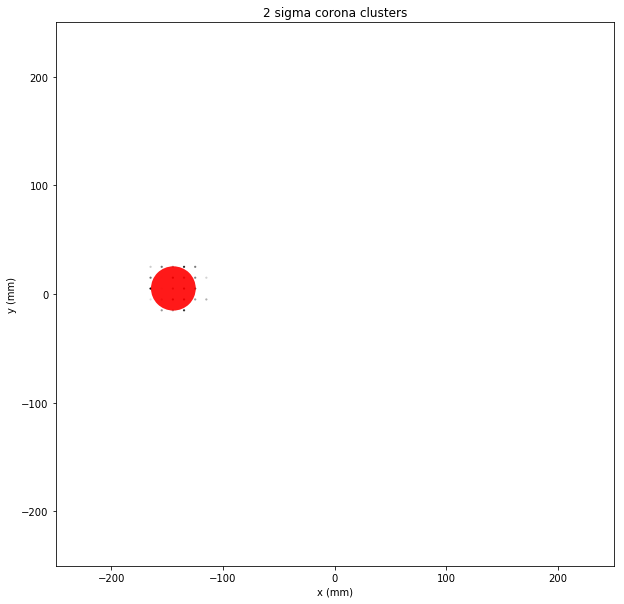

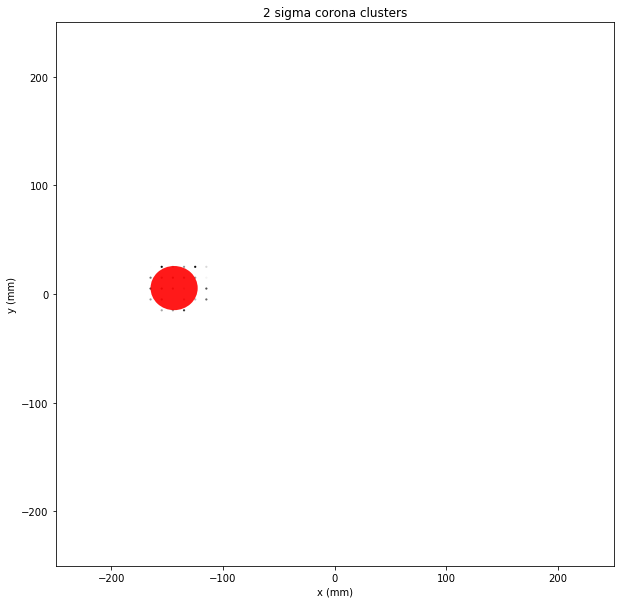

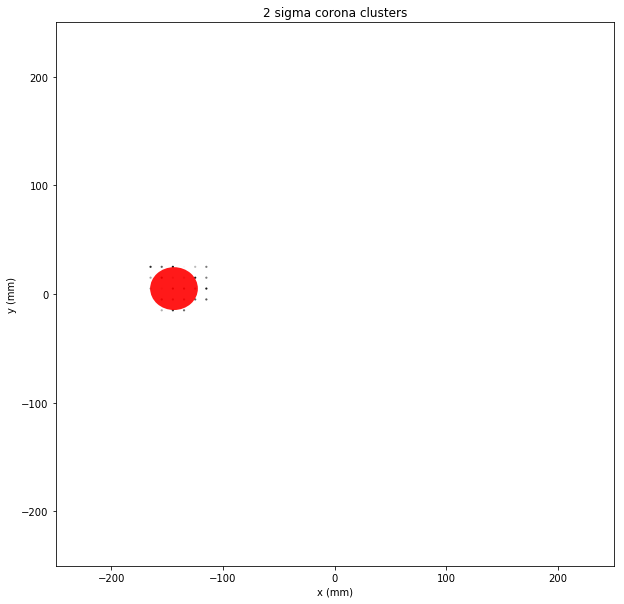

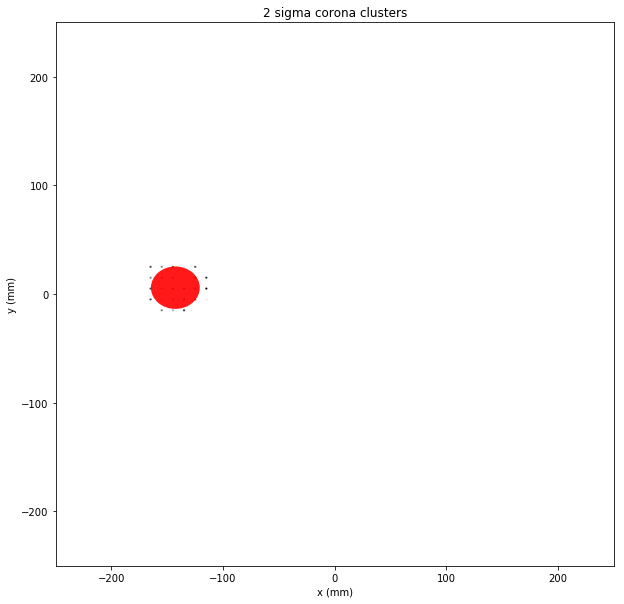

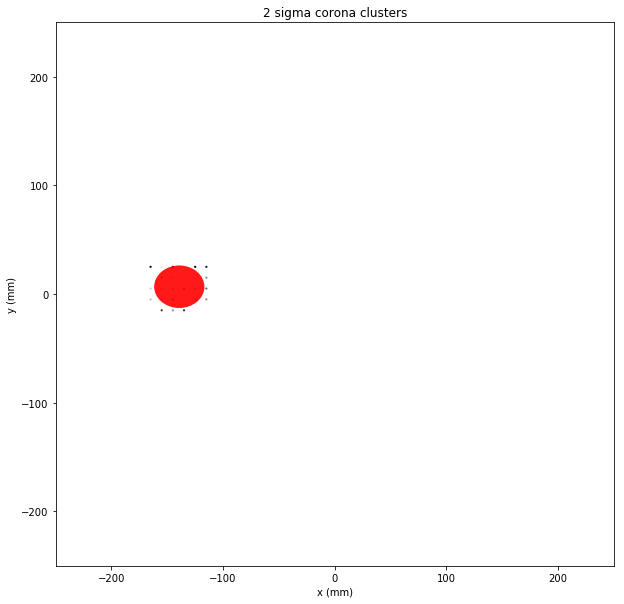

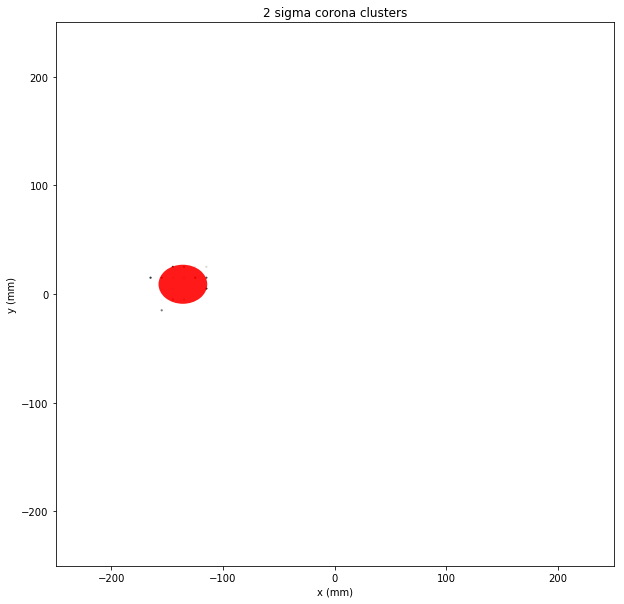

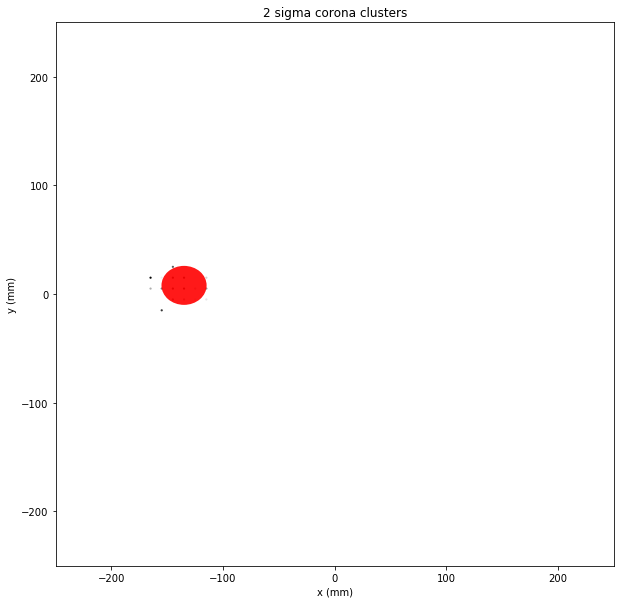

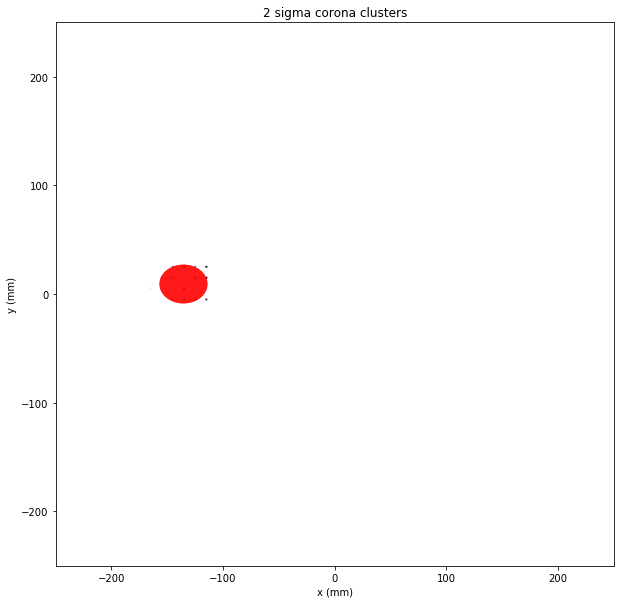

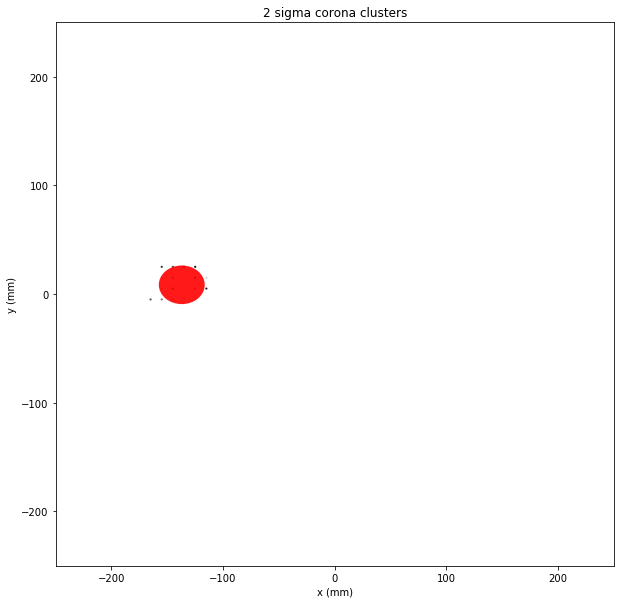

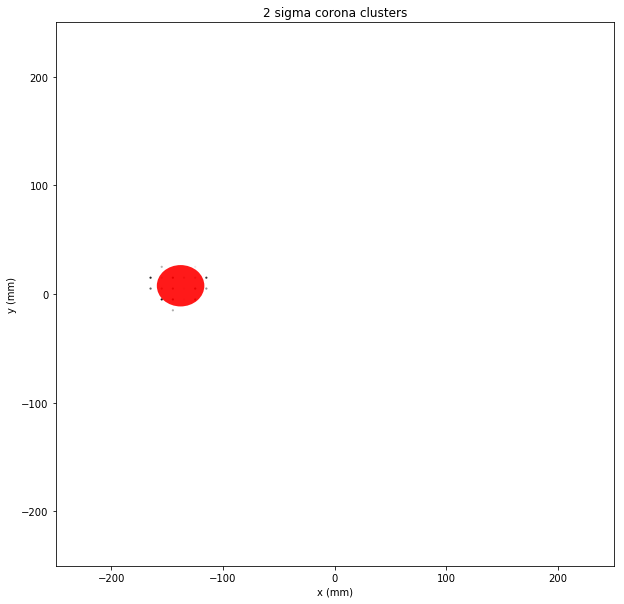

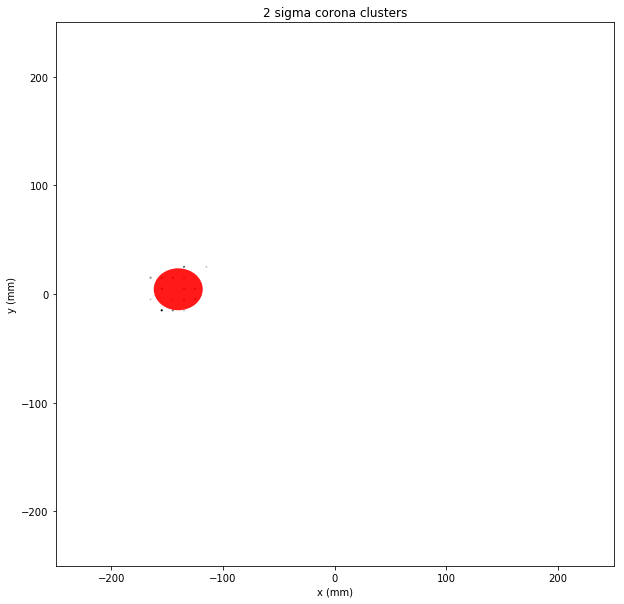

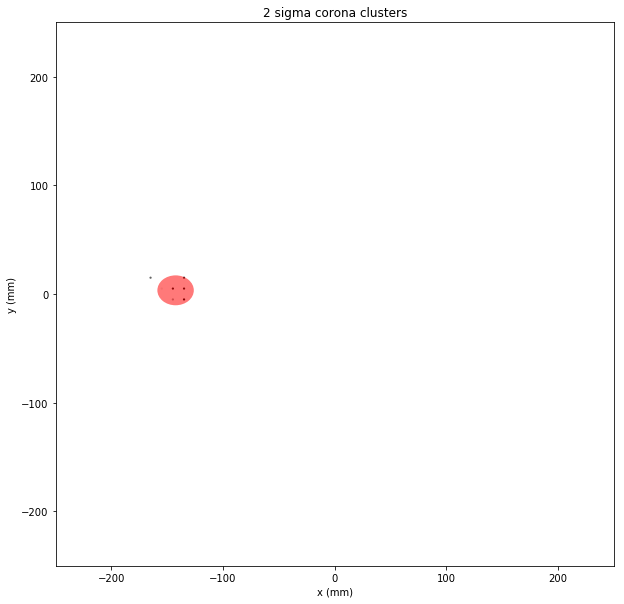

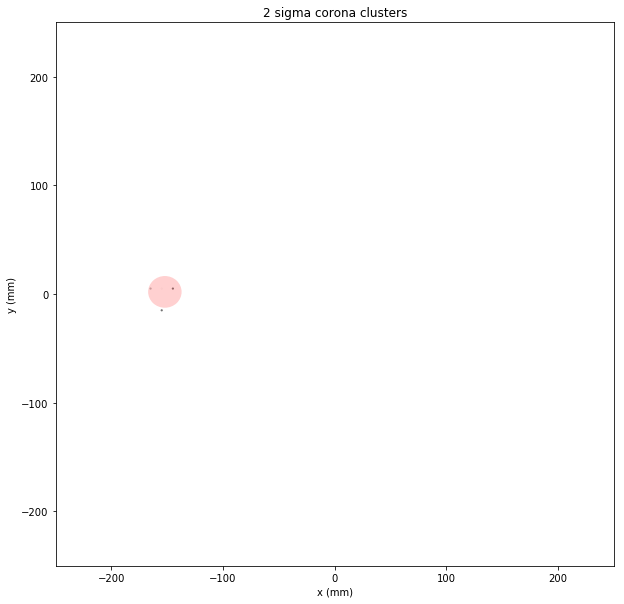

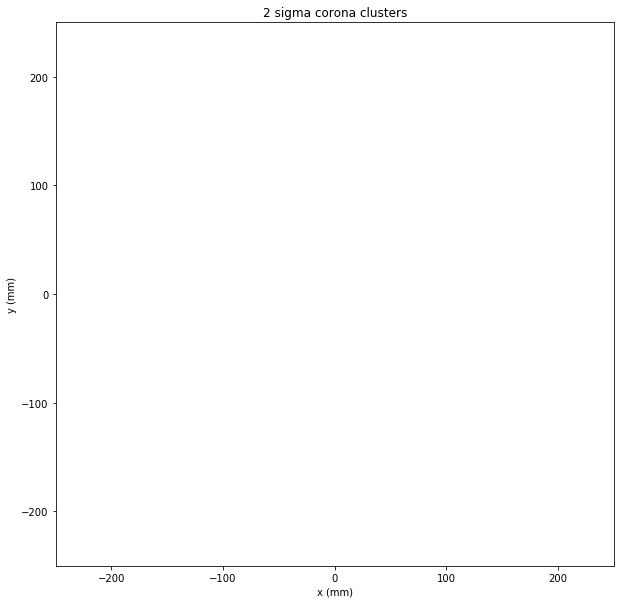

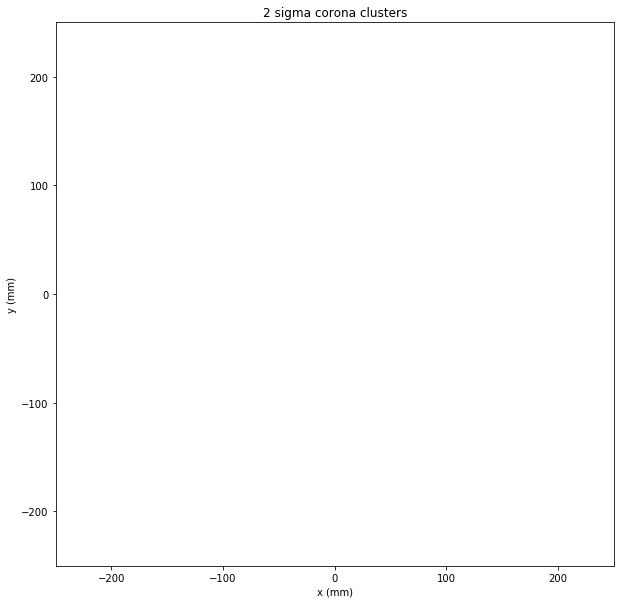

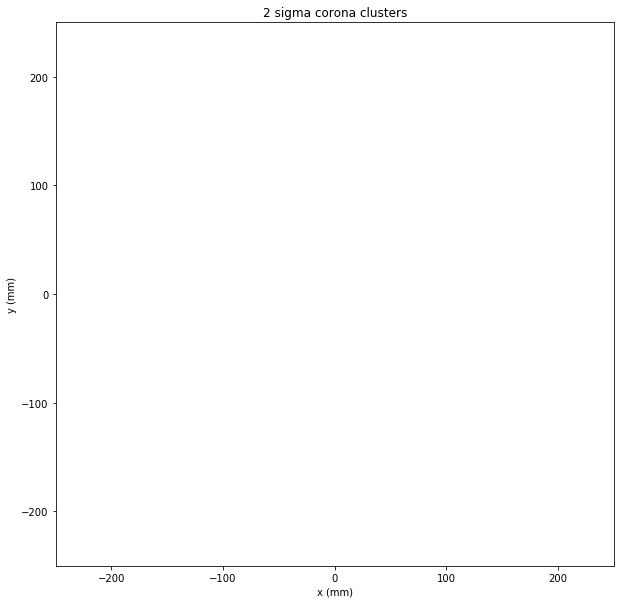

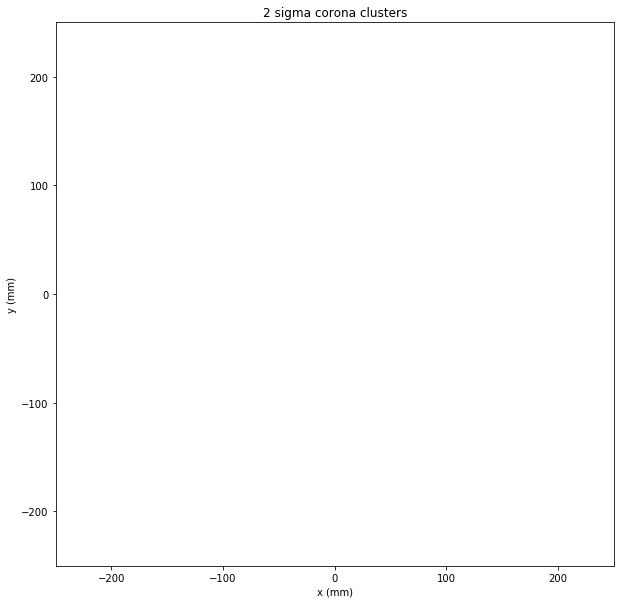

In [174]:
T     =  5*units.pes
msipm =  8
rmax  = 30*units.mm # if < 10mm won't see plots because xrms,yrms=0 sicne pitch=10mm
nsig  =  2 # plot param: ellipses with width 2*nsig*Xrms and height 2*nsig*Yrms

peak=0

S1 = S1s  .get(event_number, {})
S2 = S2s  .get(event_number, {})
Si = S2Sis.get(event_number, {})
n_slices     = len(Si[peak][next(iter(Si[peak]))])
evt_clusters = []
for slice_no in range(n_slices):
    clusters = compute_xy_position(Si[peak], slice_no)
    evt_clusters.append(clusters)
    
    # Plot SiPMS
    ax = plot_test_slice(*plot_helper(Si[peak], slice_no))
    
    # Plot corona clusters
    for c in clusters: 
        e=Ellipse(xy=(c.X,c.Y), width=2*nsig*c.Xrms, height=2*nsig*c.Yrms)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(min(.90, c.Q / 200.0*units.pes))
        e.set_facecolor('red')

    plt.title(str(nsig) + ' sigma corona clusters')
    

In [175]:
def plot_event_clusters(ECs, zstart=0*units.mus, figsize=(30,30)):
    fig = plt.figure(figsize=figsize)
    zrange  = units.mus * np.array(range(len(ECs))) + zstart
    xs = []
    ys = []
    zs = []
    qs = []
    xrms = []
    yrms = []
    for i in range(len(ECs)):
        for C in ECs[i]:
            xs.append(C.X)
            ys.append(C.Y)
            zs.append(zrange[i])
            qs.append(C.Q)
            xrms.append(C.Xrms)
            yrms.append(C.Yrms)
   
    xs = np.array(xs); ys = np.array(ys);  qs = np.array(qs); 
    zs = np.array(zs) / units.mus
    
    reds  = np.array(qs) / np.array(qs).max()
    color = np.zeros((len(reds),3),dtype=np.float32)
    color[:,0] = reds
    ax = fig.add_subplot(211, projection='3d')
    s1=ax.scatter(zs, xs, ys, c=color,
                   vmin=0,
                   vmax=color.max(),
                   s=np.pi*((np.array(xrms) + np.array(yrms)) / 2 * 3)**2,
                   edgecolors='None', alpha=1)
    ax.set_xlabel('z (microseconds)')
    ax.set_ylabel('x (mm)')
    ax.set_zlabel('y (mm)')
    ax.grid(True)
    return ax

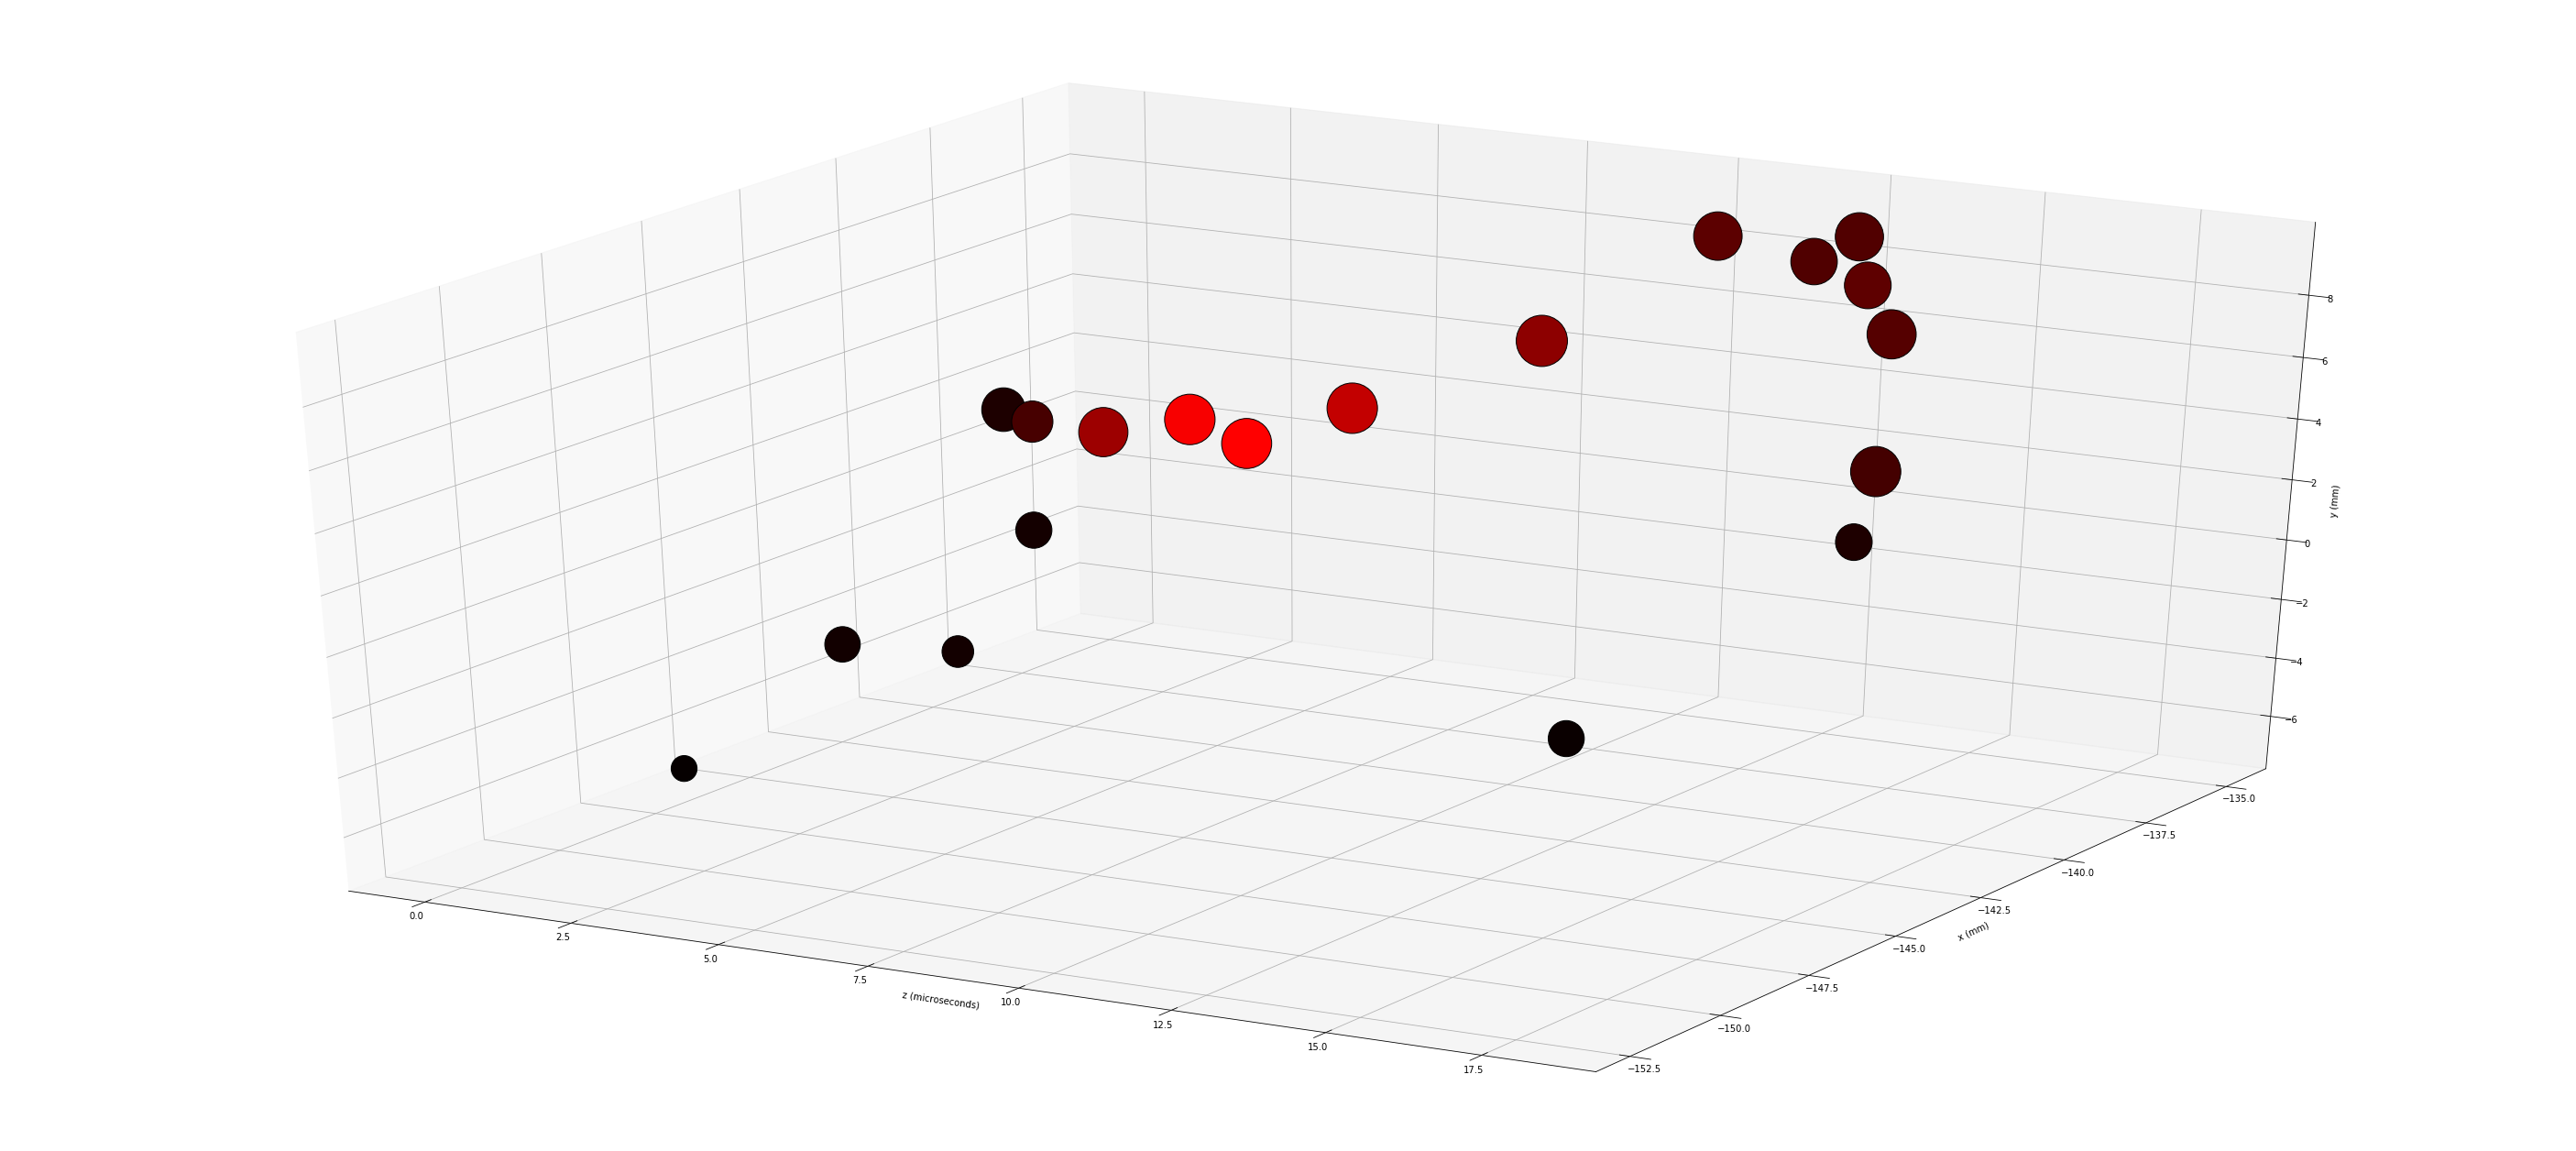

In [176]:
ax = plot_event_clusters(evt_clusters, figsize=(50,50))